In [2]:
import gerrychain
from gerrychain import (
    MarkovChain,
    constraints,
    accept
)
from gerrychain.proposals import recom
from gerrychain.tree import recursive_seed_part, bipartition_tree
from functools import partial
from tqdm import tqdm
import pandas as pd
import os
import click
import random
from division_aware import *
import matplotlib.pyplot as plt
from utilities import *

In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
graph = Graph.from_json("shapes/wisconsin2020_graph_cousub.json")
munis, nodes_by_muni = get_divisions(graph, "COUSUB")
counties, nodes_by_county = get_divisions(graph, "COUNTYFP")

In [41]:
epsilon = 0.02
steps = 1000
first_check_division = True
division_aware = True
tuple_type = "COUNTY_PREF"
POP_COL = "TOTPOP19"

if tuple_type == "COUNTYFP" or tuple_type == "COUSUB_ID":
    division_tuples = [(tuple_type, 1)]
elif tuple_type == "BOTH_EQUAL":
    division_tuples = [("COUNTYFP", 1), ("COUSUB_ID", 1)]
elif tuple_type == "COUNTY_PREF":
    division_tuples = [("COUNTYFP", 2), ("COUSUB_ID", 1)]
elif tuple_type == "MUNI_PREF":
    division_tuples = [("COUNTYFP", 1), ("COUSUB_ID", 2)]
else:
    raise ValueError("ERROR: `tuple_type` needs to be one of 'COUNTYFP', COUSUB_ID', 'BOTH_EQUAL', 'COUNTY_PREF', or 'MUNI_PREF'.")
    
def L1(vec):
    return sum(abs(v) for v in vec)

def guided_acceptance_factory(elections):

    def accept_more_proportional(partition):
        parent = partition.parent
        child_v = proportionality_vector(partition, elections)
        parent_v = proportionality_vector(parent, elections)
        child_score = L1(child_v)
        parent_score = L1(parent_v)
        probability = min([1*math.exp(180*(parent_score - child_score)), 1])
        if random.random() < probability:
            return True
        else:
            return False
    return accept_more_proportional

initial_partition = make_partition_from_districtr_csv("WI", graph, "WI1")
ideal_population = sum(initial_partition.population.values()) / len(initial_partition)
if division_aware:
    proposal = partial(recom,
                       pop_col = POP_COL,
                       pop_target = ideal_population,
                       epsilon = epsilon,
                       method = partial(division_bipartition_tree,
                                       division_tuples=division_tuples,
                                       first_check_division = first_check_division),
                       node_repeats = 2)
else:
    proposal = partial(recom,
                       pop_col=POP_COL,
                       pop_target=ideal_population,
                       epsilon=epsilon,
                       node_repeats=2)

elections = states["WI"]["elections"].keys()
acceptance = guided_acceptance_factory(elections)

chain = MarkovChain(
                    proposal = proposal,
                    constraints = [constraints.within_percent_of_ideal_population(initial_partition, epsilon)],
                    accept = acceptance,
                    initial_state = initial_partition,
                    total_steps = steps)


In [1]:
split_counties = []
split_munis = []
proportionality_L1s = []
lowest_split_counties = None
lowest_split_munis = None
lowest_split_sum = None
best_plan_counties = None
best_plan_munis = None
best_plan_sum = None
for i, part in enumerate(chain.with_progress_bar()):
    num_split_counties = num_division_splits(graph, part, counties, nodes_by_county, division_col="COUNTYFP")
    num_split_munis = num_division_splits(graph, part, munis, nodes_by_muni, division_col="COUSUB_ID")
    proportionality_L1 = L1(proportionality_vector(part, elections))
    split_counties.append(num_split_counties)
    split_munis.append(num_split_munis)
    proportionality_L1s.append(proportionality_L1)
    if lowest_split_counties is None or num_split_counties <= lowest_split_counties:
        lowest_split_counties = num_split_counties
        best_plan_counties = part
    if lowest_split_munis is None or num_split_munis <= lowest_split_munis:
        lowest_split_munis = num_split_munis
        best_plan_munis = part
    if lowest_split_sum is None or num_split_counties + num_split_munis <= lowest_split_sum:
        lowest_split_sum = num_split_counties + num_split_munis
        best_plan_sum = part

NameError: name 'chain' is not defined

In [21]:
# baseline_split_counties = split_counties
# baseline_split_munis = split_munis

Text(0.5, 1.0, 'Split Munis')

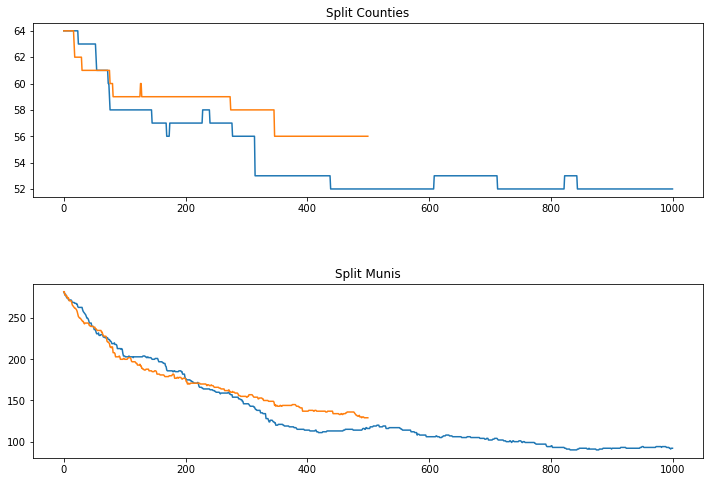

In [43]:
fig, ax = plt.subplots(2,1,figsize=(12,8))
plt.subplots_adjust(hspace=0.5)
ax[0].plot(split_counties)
ax[0].plot(baseline_split_counties)
ax[0].set_title("Split Counties")
ax[1].plot(split_munis)
ax[1].plot(baseline_split_munis)
ax[1].set_title("Split Munis")

In [16]:
save_partition_as_districtr_csv(graph, best_plan_sum, "Code-2", "best_plan_sum_test")
save_partition_as_districtr_csv(graph, best_plan_counties, "Code-2", "best_plan_counties_test")
save_partition_as_districtr_csv(graph, best_plan_munis, "Code-2", "best_plan_munis_test")

In [82]:
num_division_splits(graph, best_plan_counties, counties, nodes_by_county, division_col="COUNTYFP")

50

In [83]:
num_division_splits(graph, best_plan_munis, munis, nodes_by_muni, division_col="COUSUB_ID")

90

In [84]:
print(num_division_splits(graph, best_plan_sum, counties, nodes_by_county, division_col="COUNTYFP"))
print(num_division_splits(graph, best_plan_sum, munis, nodes_by_muni, division_col="COUSUB_ID"))

50
90


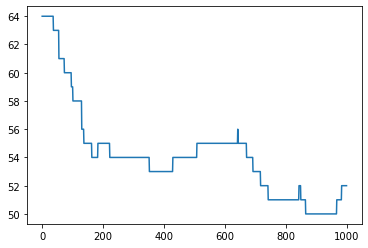

In [85]:
plt.plot(split_counties)

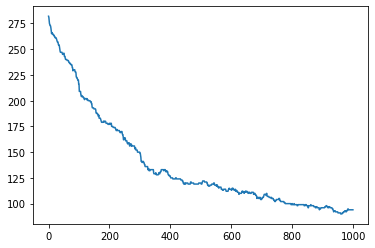

In [86]:
plt.plot(split_munis)

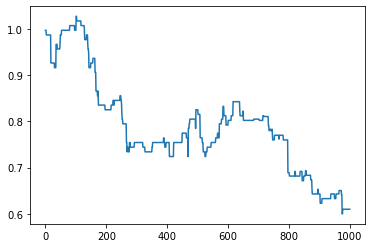

In [87]:
plt.plot(proportionality_L1s)

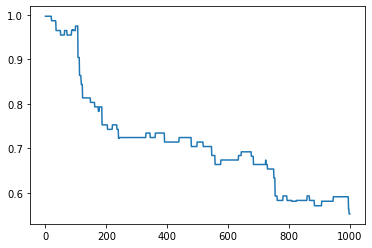

In [91]:
plt.plot(proportionality_L1s) # e^180x